#### ML Linear Regression model to learn High Entropy Alloy Hardness Property

In [1]:
# Importing Libraries

import pandas as pd  # To play with data tables
import matplotlib.pyplot as plt  # To visualize data
import numpy as np
import copy

In [2]:
# importing the models from the scikit library
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

In [3]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV

In [4]:
# Lading the material characteristic data set
data = pd.read_csv('alloy-confp-train-data_v2 (1).csv')
data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni
0,7,139,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000
1,48,295,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846
2,108,545,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222
3,146,701,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857
4,37,207,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818
...,...,...,...,...,...,...,...,...
115,42,249,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667
116,72,450,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059
117,73,451,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667
118,135,617,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667


#### Notes about the data table

Above we see that data table has 3 types of columns:
*  ID: Serial number of the alloys.
*  HV: This is the experimentally measured hardness values of the alloys. Our target property (y).    
*  C.*: concentration of different elements in the alloys.

### Separate X and y data

In [5]:
# dividing the data set 

Xcols = data.columns[data.columns.str.contains("C.")]
X = data[Xcols]
X

,C.al,C.co,C.cr,C.cu,C.fe,C.ni
0,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000
1,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846
2,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222
3,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857
4,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818
...,...,...,...,...,...,...
115,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667
116,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059
117,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667
118,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667


In [6]:
y = data['HV']
y

0      139
1      295
2      545
3      701
4      207
      ... 
115    249
116    450
117    451
118    617
119    171
Name: HV, Length: 120, dtype: int64

## Visualize Data

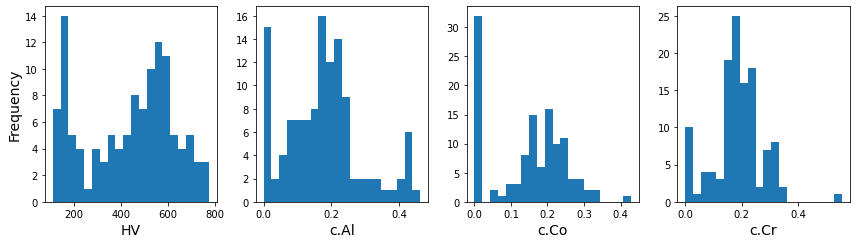

In [7]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12,3.5))

ax1.hist(y.values, bins=20)
ax2.hist(X.values[:,0], bins=20, label='c.Al')
ax3.hist(X.values[:,1], bins=20, label='c.Co')
ax4.hist(X.values[:,2], bins=20, label='c.Cr')

ax1.set_xlabel('HV', fontsize=14)
ax2.set_xlabel('c.Al', fontsize=14)
ax3.set_xlabel('c.Co', fontsize=14)
ax4.set_xlabel('c.Cr', fontsize=14)

ax1.set_ylabel('Frequency', fontsize=14)

plt.tight_layout()

## Training the ML model

In [8]:
# First we will define function to make plots. This will make the code simpler.

def polt_parity(y_cv_test,y_pred_test, y_cv_train=None,y_pred_train=None, label=None, ylim=[50,900]):
    """
    Function to make parity plots.
    """
    
    # Plot Parity plot
    rmse_test = np.sqrt(mean_squared_error(y_cv_test,y_pred_test))
    r2_test = r2_score(y_cv_test,y_pred_test)
    
    if y_cv_train is None:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharey=True, sharex=True)
    else:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=True)
        
    ax1.scatter(y_cv_test,y_pred_test)
    ax1.text(0.95, 0.26, label, transform=ax1.transAxes, ha='right', fontsize=14)    
    ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_test, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.text(0.95, 0.1, "R$^2$: %.2f"%r2_test, transform=ax1.transAxes, ha='right', fontsize=14)    
    ax1.plot(ylim, ylim, '--k')
    ax1.set_xlabel('True y', fontsize=14)
    ax1.set_ylabel('Pred y', fontsize=14)
    ax1.set_xlim(ylim[0],ylim[1])
    ax1.set_ylim(ylim[0],ylim[1])    
    
    if y_cv_train is not None: 
        rmse_train = np.sqrt(mean_squared_error(y_cv_train,y_pred_train))
        r2_train = r2_score(y_cv_train,y_pred_train)
        
        ax2.scatter(y_cv_train,y_pred_train, c='m')
        ax2.text(0.95, 0.26, "Train", transform=ax2.transAxes, ha='right', fontsize=14)        
        ax2.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax2.transAxes, ha='right', fontsize=14)    
        ax2.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax2.transAxes, ha='right', fontsize=14)        
        ax2.plot(ylim, ylim, '--k')

        ax2.set_xlabel('True y', fontsize=14)    
        ax2.set_xlim(ylim[0],ylim[1])
        ax2.set_ylim(ylim[0],ylim[1])    

    plt.tight_layout()
    plt.show()
    
    return None

## Own LR ML code using the mathematical Equation

In [9]:
X_tras_X_inv = np.linalg.inv(np.dot(X.T,X))
# this is x transpose x

X_tras_y = np.dot(X.T,y)
# X transpose y

w_cap_vec = np.dot(X_tras_X_inv,X_tras_y)
# w vector 


y_pred_manual = np.dot(X,w_cap_vec)
#  the predicted

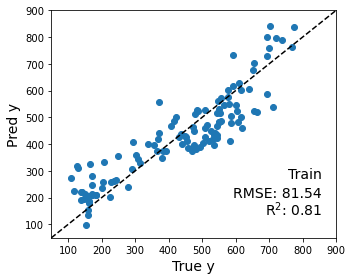

In [10]:
polt_parity(y,y_pred_manual, label="Train")

## Using Sklearn in-built Python Library

In [11]:
lr = LinearRegression(fit_intercept=False)
model = lr.fit(X,y)
lr_model = copy.deepcopy(model)

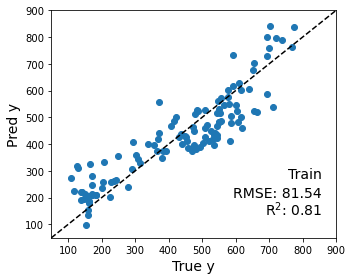

In [12]:
y_pred = model.predict(X)
polt_parity(y,y_pred, label="Train")

## Using Sklearn Library model vs mathematical made Equation results

In [13]:
print("Sklearn model: ", lr_model.coef_)
print("Eq. based model: ", w_cap_vec)

Sklearn model:  [1589.03703891  154.02145017  647.00169133  279.68594241  204.32826373
 -241.42532589]
Eq. based model:  [1589.03703891  154.02145017  647.00169133  279.68594241  204.32826373
 -241.42532589]


## Error with Baseline Average Model

In [14]:
y_avg_pred = [y.mean()]*len(y)
print("Root mean squared error: %.2f" % np.sqrt(mean_squared_error(y, y_avg_pred)))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_avg_pred))

Root mean squared error: 186.35
Coefficient of determination: 0.00


## Model assessment , cross-validation

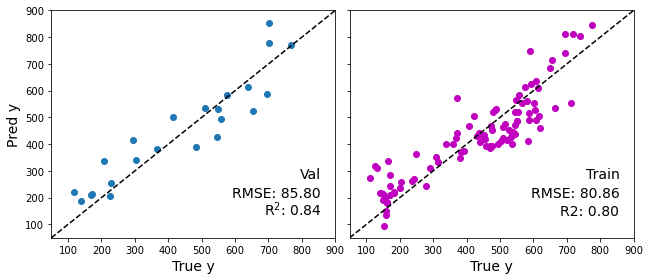

Root mean squared error: 85.80
Coefficient of determination: 0.84


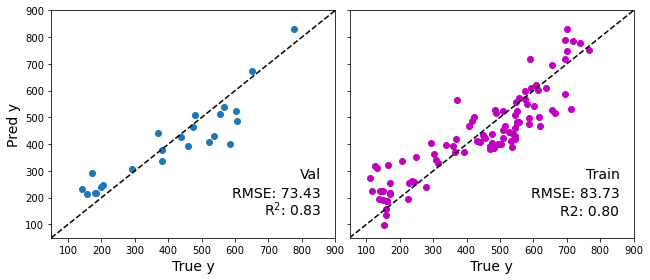

Root mean squared error: 73.43
Coefficient of determination: 0.83


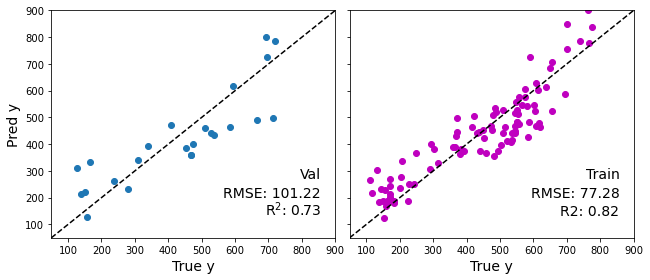

Root mean squared error: 101.22
Coefficient of determination: 0.73


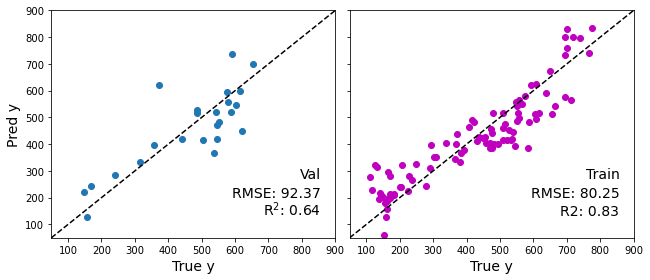

Root mean squared error: 92.37
Coefficient of determination: 0.64


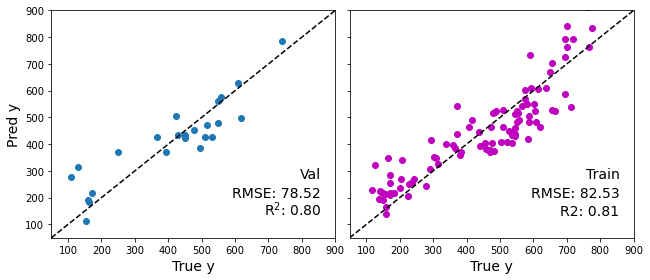

Root mean squared error: 78.52
Coefficient of determination: 0.80


In [15]:
kf = KFold(n_splits=5)

errors = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]
    
    
    # Model fit and prediction
    model = lr.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    
    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val) 
    
    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,             
             'rmse_val': rmse_val,
             'r2_val': r2_val
            }

    errors.append(error)

In [16]:
errors = pd.DataFrame(errors)
errors

,kfold,rmse_train,r2_train,rmse_val,r2_val
0,1,80.864286,0.795547,85.799257,0.837913
1,2,83.732501,0.800274,73.432834,0.834738
2,3,77.280666,0.823255,101.215500,0.733636
3,4,80.246476,0.826733,92.368961,0.638148
4,5,82.527396,0.807746,78.516907,0.801528


In [17]:
errors[['rmse_val','r2_val']].mean()

rmse_val    86.266692
r2_val       0.769193
dtype: float64

## Polynomial Regression

### Building Polynomial Features

In [18]:
new_data = data.copy()

In [19]:
def make_new_feature(data, cols, powers, new_col_name):
    """
    Function to create new features:
    Example: 
    Input: cols = x1,x2; powers = 2,3; new_col_name = n1
    Output: n1= x1**2 * x2**3
    """
    data[new_col_name] = 1
    for power, col in zip(powers, cols):
        data[new_col_name] = data[new_col_name] * (data[Xcols[col]] ** power)
        
    return data

In [20]:
cols = [0,1]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.1')

In [21]:
new_data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni,n.1
0,7,139,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,0.000000
1,48,295,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846,0.047337
2,108,545,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.024691
3,146,701,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,0.091837
4,37,207,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,0.016529
...,...,...,...,...,...,...,...,...,...
115,42,249,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.055556
116,72,450,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059,0.000000
117,73,451,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667,0.041667
118,135,617,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667,0.027778


In [22]:
cols = [1,3]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.2')

cols = [2,4]
powers = [1,2]
new_data = make_new_feature(new_data, cols, powers, 'n.3')

cols = [3,4,5]
powers = [1,1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.4')

cols = [4,5]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'n.5')

In [23]:
new_data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni,n.1,n.2,n.3,n.4,n.5
0,7,139,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,0.000000,0.000000,0.015625,0.000000,0.062500
1,48,295,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846,0.047337,0.023669,0.003641,0.001821,0.023669
2,108,545,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.024691,0.024691,0.000000,0.010974,0.049383
3,146,701,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,0.091837,0.015306,0.000364,0.000729,0.010204
4,37,207,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,0.016529,0.033058,0.006011,0.006011,0.033058
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,42,249,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.055556,0.055556,0.000000,0.004630,0.027778
116,72,450,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059,0.000000,0.000000,0.057246,0.000000,0.064879
117,73,451,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667,0.041667,0.020833,0.004630,0.002315,0.027778
118,135,617,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667,0.027778,0.000000,0.009259,0.000000,0.027778


In [24]:
Xcols = new_data.columns[new_data.columns.str.contains("C.") | new_data.columns.str.contains("n.")]
X = new_data[Xcols]
X

,C.al,C.co,C.cr,C.cu,C.fe,C.ni,n.1,n.2,n.3,n.4,n.5
0,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,0.000000,0.000000,0.015625,0.000000,0.062500
1,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846,0.047337,0.023669,0.003641,0.001821,0.023669
2,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.024691,0.024691,0.000000,0.010974,0.049383
3,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,0.091837,0.015306,0.000364,0.000729,0.010204
4,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,0.016529,0.033058,0.006011,0.006011,0.033058
...,...,...,...,...,...,...,...,...,...,...,...
115,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.055556,0.055556,0.000000,0.004630,0.027778
116,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059,0.000000,0.000000,0.057246,0.000000,0.064879
117,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667,0.041667,0.020833,0.004630,0.002315,0.027778
118,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667,0.027778,0.000000,0.009259,0.000000,0.027778


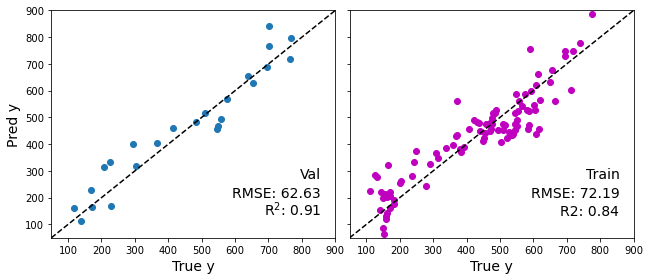

Root mean squared error: 62.63
Coefficient of determination: 0.91


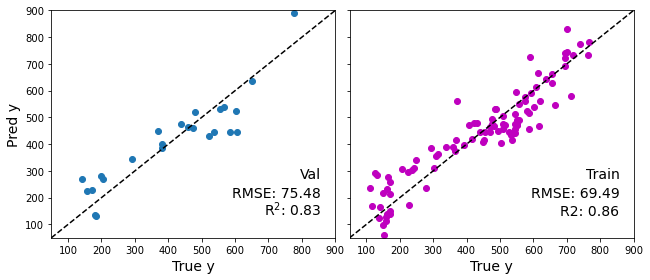

Root mean squared error: 75.48
Coefficient of determination: 0.83


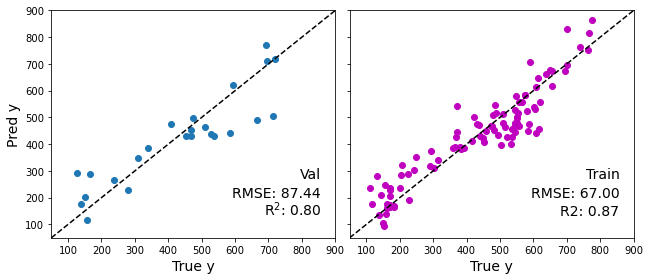

Root mean squared error: 87.44
Coefficient of determination: 0.80


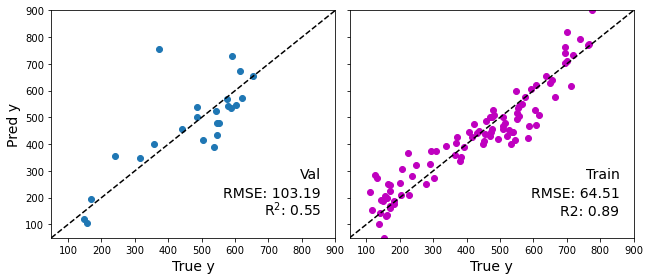

Root mean squared error: 103.19
Coefficient of determination: 0.55


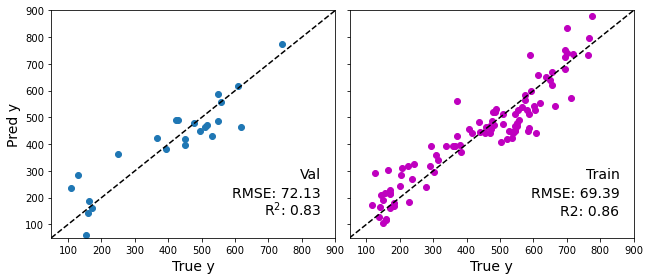

Root mean squared error: 72.13
Coefficient of determination: 0.83


In [25]:
kf = KFold(n_splits=5)

errors_pr = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]
    
    
    # Model fit and prediction
    model = lr.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    
    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val) 
    
    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,             
             'rmse_val': rmse_val,
             'r2_val': r2_val
            }

    errors_pr.append(error)
errors_pr = pd.DataFrame(errors_pr)    

In [26]:
errors_pr[['rmse_val','r2_val']].mean()

rmse_val    80.175233
r2_val       0.784219
dtype: float64

In [27]:
errors[['rmse_val','r2_val']].mean()

rmse_val    86.266692
r2_val       0.769193
dtype: float64

## Regularization

In [28]:
pr_l2 = Ridge(alpha=1)

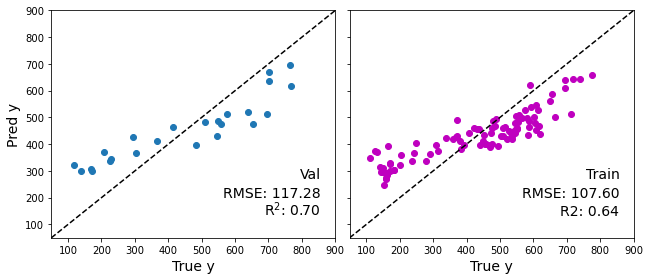

Mean squared error: 117.28
Coefficient of determination: 0.70


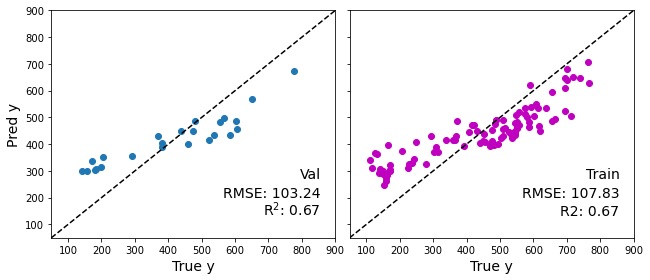

Mean squared error: 103.24
Coefficient of determination: 0.67


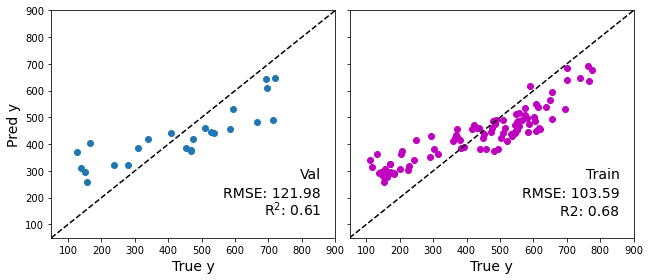

Mean squared error: 121.98
Coefficient of determination: 0.61


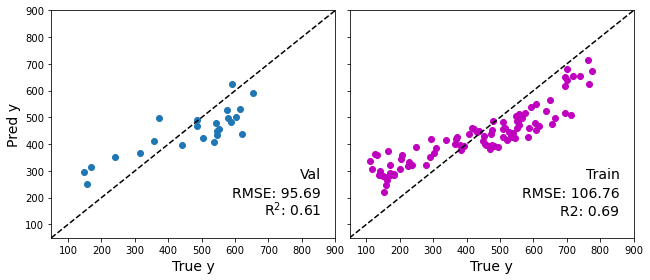

Mean squared error: 95.69
Coefficient of determination: 0.61


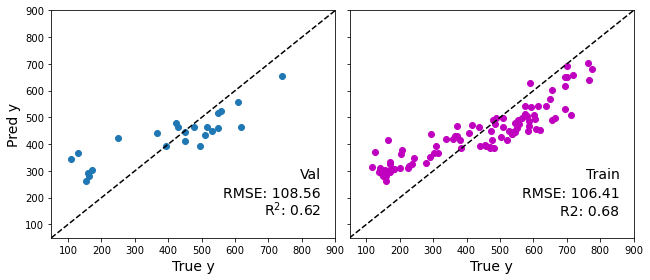

Mean squared error: 108.56
Coefficient of determination: 0.62


In [29]:
errors_pr_l2 = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]
    
    
    # Model fit and prediction
    model = pr_l2.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    
    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val) 
    
    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'r2_train': r2_train}

    errors_pr_l2.append(error)
errors_pr_l2 = pd.DataFrame(errors_pr_l2)

## Regularization with coefficent optimization

In [30]:
c_values = [0.0001, 0.0005, 0.00065, 0.0008, 0.001, 0.0012, 0.0014, 0.002, 0.01, 0.05, 0.1, 1, 2]
hyper_params = {'alpha':c_values}

In [31]:
lr_ridge = Ridge()
clf = GridSearchCV(lr_ridge, hyper_params, cv=5, scoring='neg_mean_squared_error')

In [32]:
_ = clf.fit(X,y)

rmse_list = np.sqrt(clf.cv_results_['mean_test_score']*-1)
rmse_list

array([ 80.37746946,  78.74822196,  78.5320316 ,  78.40731424,
        78.33075385,  78.3187628 ,  78.34695547,  78.55197774,
        81.34239268,  84.25826775,  85.24084833, 109.75686778,
       129.52780229])

Text(0, 0.5, 'RMSE')

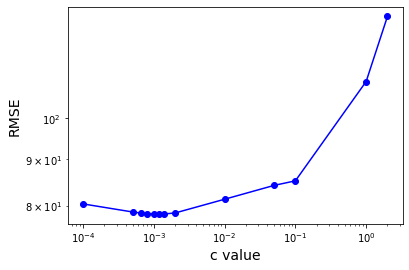

In [33]:
plt.plot(c_values, rmse_list, '-bo')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('c value', fontsize=14)
plt.ylabel('RMSE', fontsize=14)

In [34]:
min_idx = np.argmin(rmse_list)

c_values[min_idx], rmse_list[min_idx]

(0.0012, 78.31876280147227)

In [35]:
c_opt = c_values[min_idx]

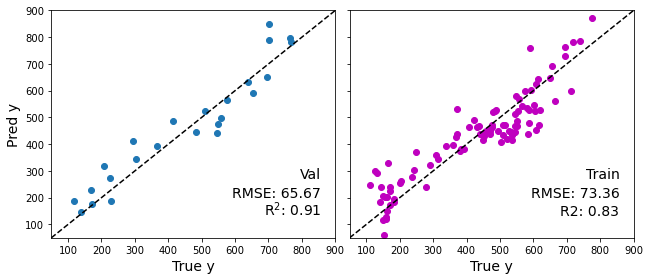

Root Mean squared error: 65.67
Coefficient of determination: 0.91


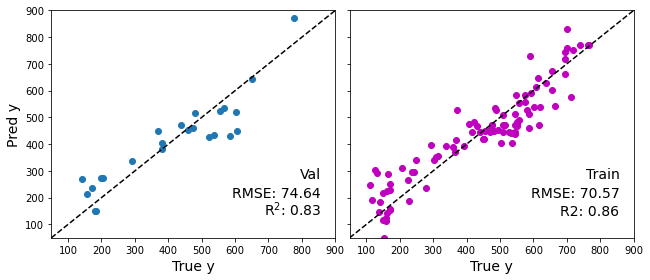

Root Mean squared error: 74.64
Coefficient of determination: 0.83


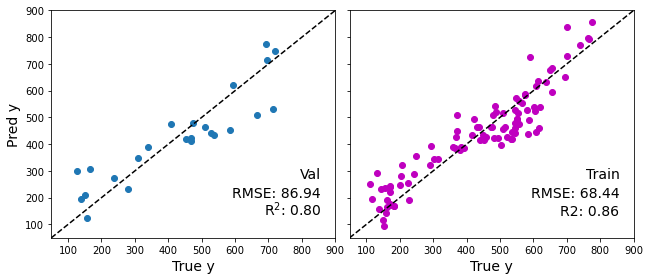

Root Mean squared error: 86.94
Coefficient of determination: 0.80


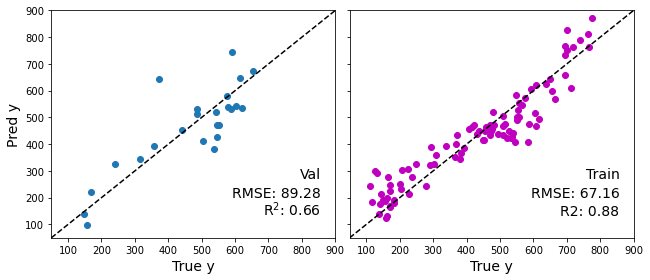

Root Mean squared error: 89.28
Coefficient of determination: 0.66


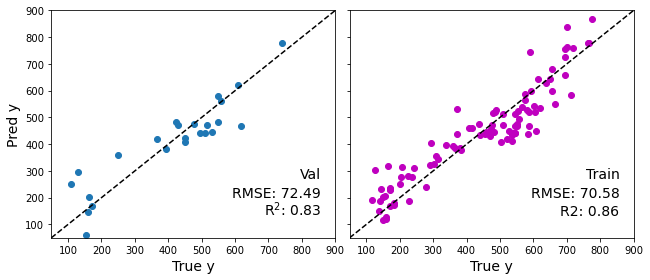

Root Mean squared error: 72.49
Coefficient of determination: 0.83


In [36]:
pr_ridge_c_opt = Ridge(alpha=c_opt)

errors_l2_c_opt = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]
    
    
    # Model fit and prediction
    model = pr_ridge_c_opt.fit(X_cv_train,y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)
    
    
    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Root Mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val) 
    
    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'r2_train': r2_train}

    errors_l2_c_opt.append(error)
errors_l2_c_opt = pd.DataFrame(errors_l2_c_opt)

In [37]:
errors_l2_c_opt[['rmse_val','r2_val']].mean()

rmse_val    77.805559
r2_val       0.806103
dtype: float64

## Comparing performance of all models trained

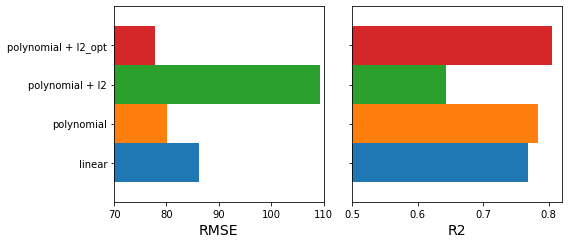

In [38]:
width = 0.1
labels = ['linear','polynomial','polynomial + l2','polynomial + l2_opt']
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), sharey=True)
    
for idx,e in enumerate([errors, errors_pr, errors_pr_l2, errors_l2_c_opt]):
    mse = e.mean()['rmse_val']
    r2 = e.mean()['r2_val']
    
    ax1.barh(0 + width*(idx-1), mse, height=width, label=labels[idx], align='center')
    ax2.barh(0 + width*(idx-1), r2, height=width, label=labels[idx], align='center')    
    
ax1.set_xlabel('RMSE', fontsize=14)
ax2.set_xlabel('R2', fontsize=14)    

ax1.set_yticks([-0.1,0,0.1,0.2])
ax1.set_yticklabels(labels)

ax1.set_ylim(-0.2,0.3)
ax1.set_xlim(70,110)
ax2.set_xlim(0.5,0.82)

plt.tight_layout()
plt.show()

# Thank You